In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd 
from transformers import BertTokenizer, TFBertForSequenceClassification


c:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping
from transformers import BertTokenizer, TFBertModel
import tensorflow_addons as tfa

c:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.preprocessing import LabelEncoder
from nltk.stem import WordNetLemmatizer

from nltk.tokenize import sent_tokenize,word_tokenize

In [4]:
df=pd.read_csv('D:\Brand Sentiment Analysis using NLP\Dataset\Dataset - Train.csv')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [5]:
df=df.dropna()
df.rename(columns={'is_there_an_emotion_directed_at_a_brand_or_product':'emotion',
                   'tweet_text':'text'},inplace=True)

In [6]:
def remove_tags(text):
    remove=re.compile(r'')
    return re.sub(remove, '', text)

df['text'] = df['text'].apply(remove_tags)

label_encoder = LabelEncoder()
df['emotion'] = label_encoder.fit_transform(df['emotion'])

def remove_splchr(text):
    cp=[]
    text=text.split()
    
    for i in text:
        if i.isalnum():
            cp.append(i)
        
    return " ".join(cp)

df['text']=df['text'].apply(remove_splchr)
    
df['text']=df['text'].str.lower()

df['text']=df['emotion_in_tweet_is_directed_at']+ " " + df['text']

In [7]:
df.head()

,text,emotion_in_tweet_is_directed_at,emotion
0,iPhone i have a 3g after 3 hrs tweeting at it ...,iPhone,1
1,iPad or iPhone App know about awesome app that...,iPad or iPhone App,3
2,iPad can not wait for 2 they should sale them ...,iPad,3
3,iPad or iPhone App i hope this festival as cra...,iPad or iPhone App,1
4,Google great stuff on fri marissa mayer tim ma...,Google,3


In [8]:
texts=df['text'].astype(str).values
labels=df['emotion'].astype(int).values



In [9]:
texts

array(['iPhone i have a 3g after 3 hrs tweeting at it was i need to plugin stations at',
       'iPad or iPhone App know about awesome app that likely appreciate for its giving free ts at',
       'iPad can not wait for 2 they should sale them down at', ...,
       'Other Google product or service diller says google tv be run over by the playstation and the which are essentially ready',
       'iPad or iPhone App always used for my iphone it has an image stabilizer suggestions for an ipad cam app same',
       'iPad ipad'], dtype=object)

In [10]:
X_train, X_val, y_train, y_val = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [11]:
# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [12]:
# Tokenize the input data
train_tokens = tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=128, return_tensors='tf')
val_tokens = tokenizer(X_val.tolist(), truncation=True, padding=True, max_length=128, return_tensors='tf')

In [13]:
train_tokens

{'input_ids': <tf.Tensor: shape=(2632, 36), dtype=int32, numpy=
array([[  101,  2060,  8224, ...,     0,     0,     0],
       [  101, 18059,  2154, ...,     0,     0,     0],
       [  101,  8224, 16012, ...,     0,     0,     0],
       ...,
       [  101,  6207,  2077, ...,     0,     0,     0],
       [  101,  2060,  8224, ...,     0,     0,     0],
       [  101, 18059,  4067, ...,     0,     0,     0]])>, 'token_type_ids': <tf.Tensor: shape=(2632, 36), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>, 'attention_mask': <tf.Tensor: shape=(2632, 36), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>}

In [14]:
# Extract BERT embeddings
train_embeddings = model(train_tokens['input_ids']).last_hidden_state[:, 0, :]
val_embeddings = model(val_tokens['input_ids']).last_hidden_state[:, 0, :]

In [15]:

train_embeddings


<tf.Tensor: shape=(2632, 768), dtype=float32, numpy=
array([[-0.16814469,  0.1753756 ,  0.20996937, ..., -0.3200567 ,
         0.5039404 , -0.09987885],
       [-0.35340503,  0.11944835,  0.46653426, ..., -0.09987332,
         0.6192366 , -0.17103173],
       [-0.6803945 , -0.02355409,  0.13320656, ..., -0.24183075,
         0.62605256, -0.35637987],
       ...,
       [-0.4609233 ,  0.08812487,  0.07475215, ...,  0.01132663,
         0.6073922 , -0.33330005],
       [-0.3417819 ,  0.00927798,  0.29079372, ..., -0.17462713,
         0.6242331 , -0.04300085],
       [-0.19863737,  0.06942908,  0.35575902, ..., -0.22969961,
         0.4767736 , -0.10571737]], dtype=float32)>

In [16]:
# Add additional layers if needed (e.g., Dense layers)
dense_layer = Dense(256, activation='relu')
output_logits = Dense(len(np.unique(labels)), activation='softmax')



In [17]:
# Build the model
inputs = Input(shape=(model.config.hidden_size,), name='input_embeddings')
x = dense_layer(inputs)
outputs = output_logits(x)

model = Model(inputs=inputs, outputs=outputs)

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_embeddings (InputLay  [(None, 768)]             0         
 er)                                                             
                                                                 
 dense (Dense)               (None, 256)               196864    
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 197892 (773.02 KB)
Trainable params: 197892 (773.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=[SparseCategoricalAccuracy()])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [20]:
history = model.fit(train_embeddings.numpy(), y_train, epochs=10,
                    validation_data=(val_embeddings.numpy(), y_val),
                    callbacks=[early_stopping])

Epoch 1/10


c:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


83/83 [==============================] - 1s 5ms/step - loss: 1.0853 - sparse_categorical_accuracy: 0.6193 - val_loss: 0.8763 - val_sparse_categorical_accuracy: 0.7815
Epoch 2/10
83/83 [==============================] - 0s 2ms/step - loss: 0.7345 - sparse_categorical_accuracy: 0.8108 - val_loss: 0.6779 - val_sparse_categorical_accuracy: 0.8088
Epoch 3/10
83/83 [==============================] - 0s 2ms/step - loss: 0.6326 - sparse_categorical_accuracy: 0.8116 - val_loss: 0.6177 - val_sparse_categorical_accuracy: 0.8118
Epoch 4/10
83/83 [==============================] - 0s 2ms/step - loss: 0.6023 - sparse_categorical_accuracy: 0.8116 - val_loss: 0.5948 - val_sparse_categorical_accuracy: 0.8118
Epoch 5/10
83/83 [==============================] - 0s 2ms/step - loss: 0.5898 - sparse_categorical_accuracy: 0.8119 - val_loss: 0.5841 - val_sparse_categorical_accuracy: 0.8118
Epoch 6/10
83/83 [==============================] - 0s 2ms/step - loss: 0.5829 - sparse_categorical_accuracy: 0.8119 - va

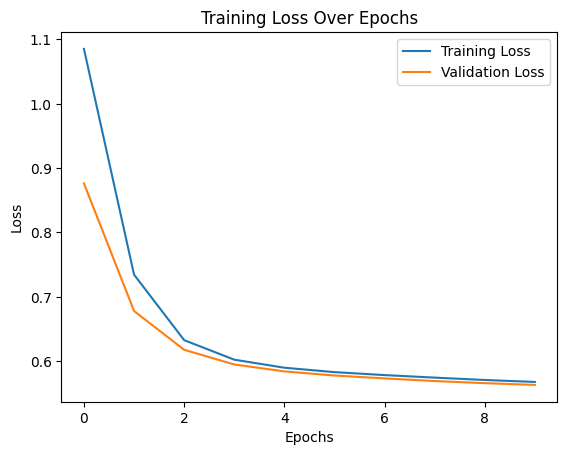

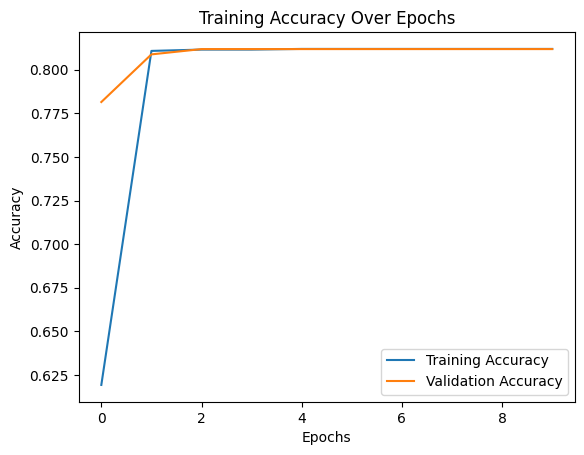

In [37]:
import matplotlib.pyplot as plt

# Assuming 'history' contains information about training
# For example, history = model.fit(...)

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
# If you have validation data, you can plot validation loss as well
plt.plot(history.history['val_loss'], label='Validation Loss')

# Customize the plot
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training accuracy
plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
# If you have validation data, you can plot validation accuracy as well
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')

# Customize the plot
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()